<div style="display: flex; background-color: RGB(255,114,0);" >
<h1 style="margin: auto; padding: 30px; ">Machine learning pour analyse des billets</h1>
</div>

<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 1 - Importation des librairies et chargement des fichiers</h2>
</div>

In [3]:
# Importer les packages nécessaires
import pandas as pd # Manipuler les dataframes
import numpy as np # Calcul matricienne

# Visualisation
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

# Préparation des données et clustering
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan, normal_ad, het_white, acorr_breusch_godfrey

# Ignorer les warning
import warnings
warnings.filterwarnings("ignore")
from tabulate import tabulate

In [4]:
#Importation du fichier CSV billets.csv
df_billets = pd.read_csv('billets.csv', delimiter=';')

<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 2 - Analyse exploratoire des fichiers</h2>
</div>

In [6]:
#Afficher toutes les informations du fichier df_billets
df_billets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


## Valeurs manquantes dans la variable margin_low = 37

In [8]:
# Analyse des variables
df_billets.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


In [9]:
#Vérifier si il y a les lignes en doublons dans le dataframe df_billets
# Identification des doublons
df_billets.duplicated().sum()

0

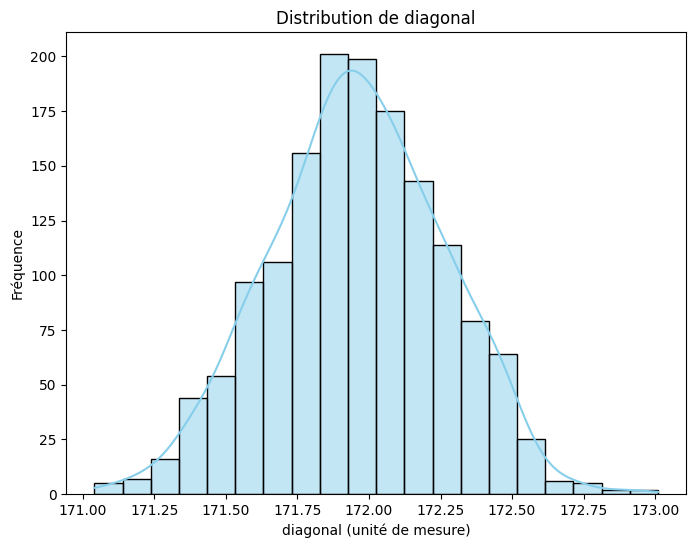

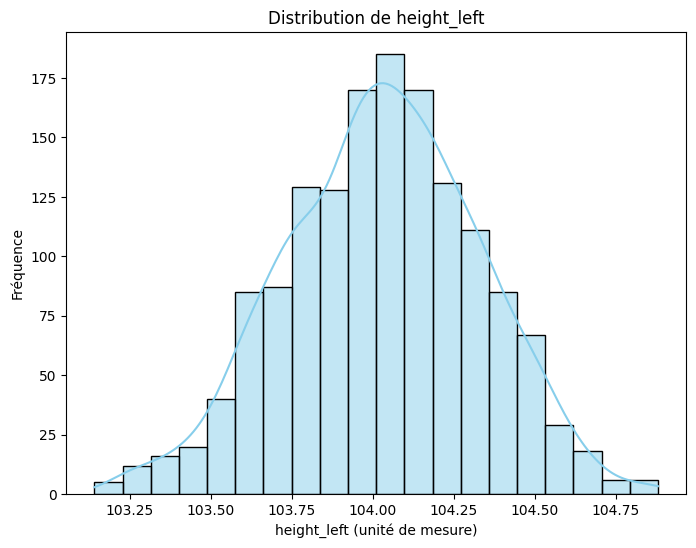

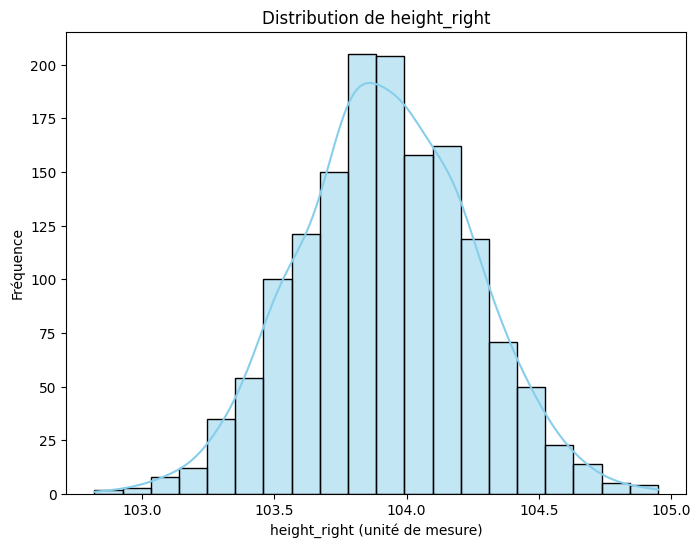

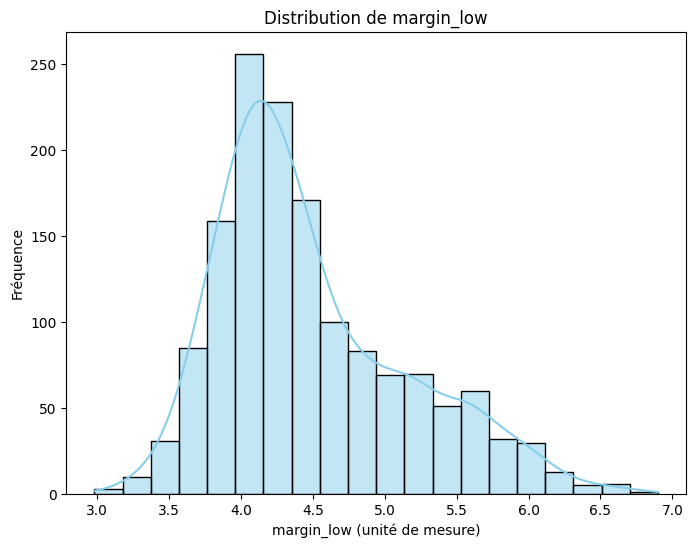

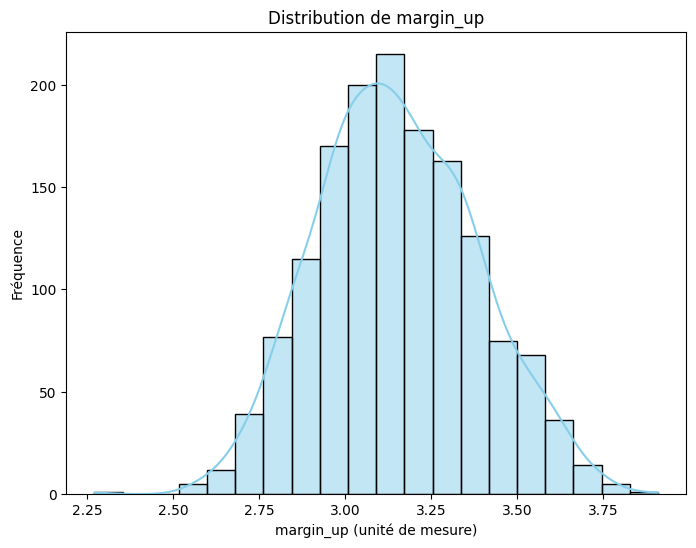

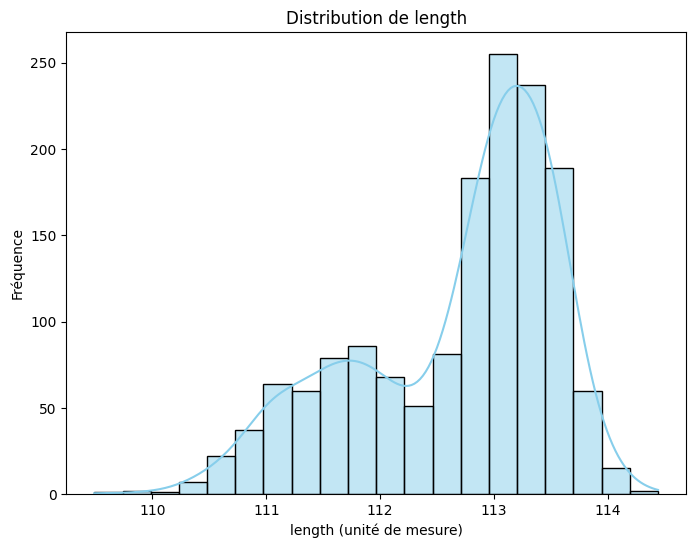

In [10]:
# On vérifie la distribution des valeurs par variable
# Histogramme pour chaque dimension des billets
dimensions = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
for dim in dimensions:
    plt.figure(figsize=(8, 6))
    sns.histplot(df_billets[dim].dropna(), bins=20, kde=True, color='skyblue')
    plt.title(f'Distribution de {dim}')
    plt.xlabel(f'{dim} (unité de mesure)')
    plt.ylabel('Fréquence')
    plt.show()

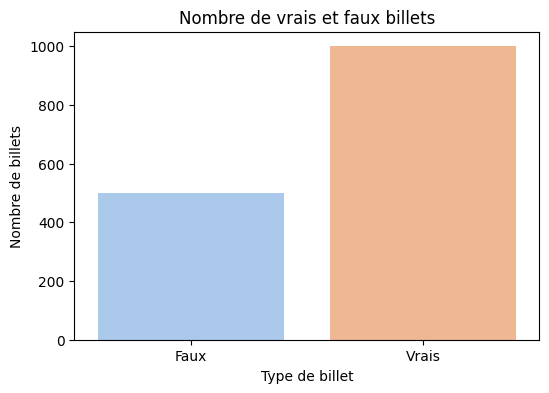

Nombre de vrais billets : 1000
Nombre de faux billets : 500


In [11]:
# Compter les vrais et faux billets
nb_vrais = df_billets['is_genuine'].sum()
nb_faux = len(df_billets) - nb_vrais  # Nombre total moins le nombre de vrais

# Créer un diagramme à barres pour visualiser
plt.figure(figsize=(6, 4))
sns.countplot(x='is_genuine', data=df_billets, palette='pastel')
plt.title('Nombre de vrais et faux billets')
plt.xlabel('Type de billet')
plt.ylabel('Nombre de billets')
plt.xticks([0, 1], ['Faux', 'Vrais'])
plt.show()

# Affichage des résultats
print(f"Nombre de vrais billets : {nb_vrais}")
print(f"Nombre de faux billets : {nb_faux}")

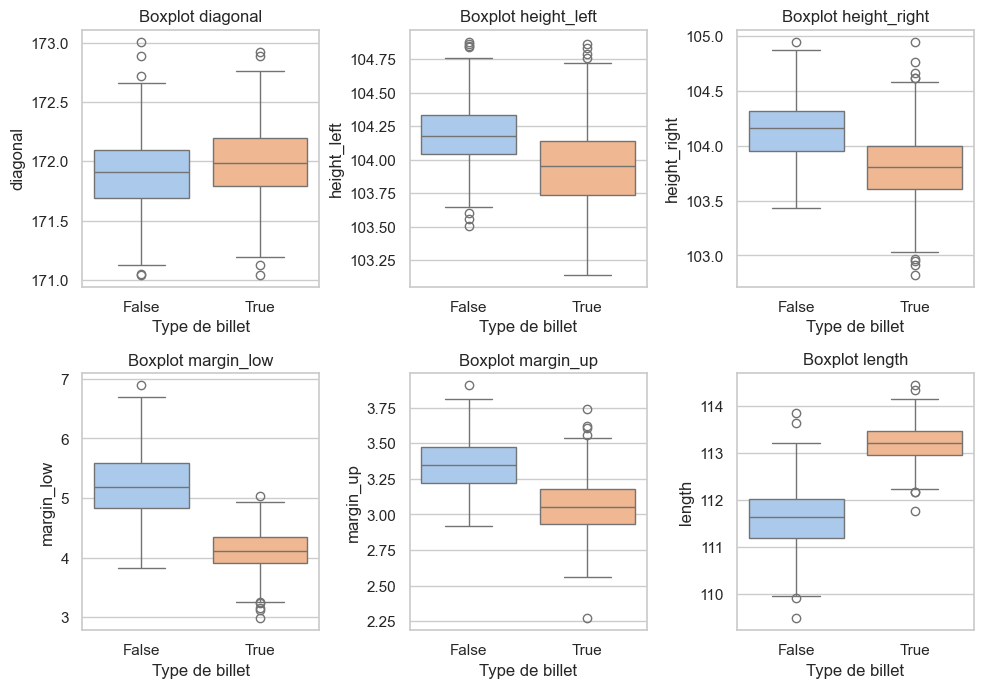

In [12]:
# Configuration
sns.set(style="whitegrid")
plt.figure(figsize=(10, 10))

# Palette de couleurs
palette = sns.color_palette("pastel", len(df_billets['is_genuine'].unique()))

columns_to_plot = df_billets.columns[1:7]  # Toutes les colonnes sauf 'is_genuine'
# Boucle à travers chaque colonne
for i, column in enumerate(columns_to_plot):
    plt.subplot(3, 3, i + 1)  # Créer une grille de 3x3
    sns.boxplot(x='is_genuine', y=column, data=df_billets, palette=palette)
    plt.title(f'Boxplot {column}')
    plt.xlabel('Type de billet')
    plt.ylabel(column)
    
# Ajuster
plt.tight_layout()

# Afficher
plt.show()

In [13]:
# Je souhaite modifier la valeur abberantes de margin _up en prenant la moyenne de la colonne 3.15
df_billets.loc[df_billets['margin_up'] < 2.5, 'margin_up'] = 3.15

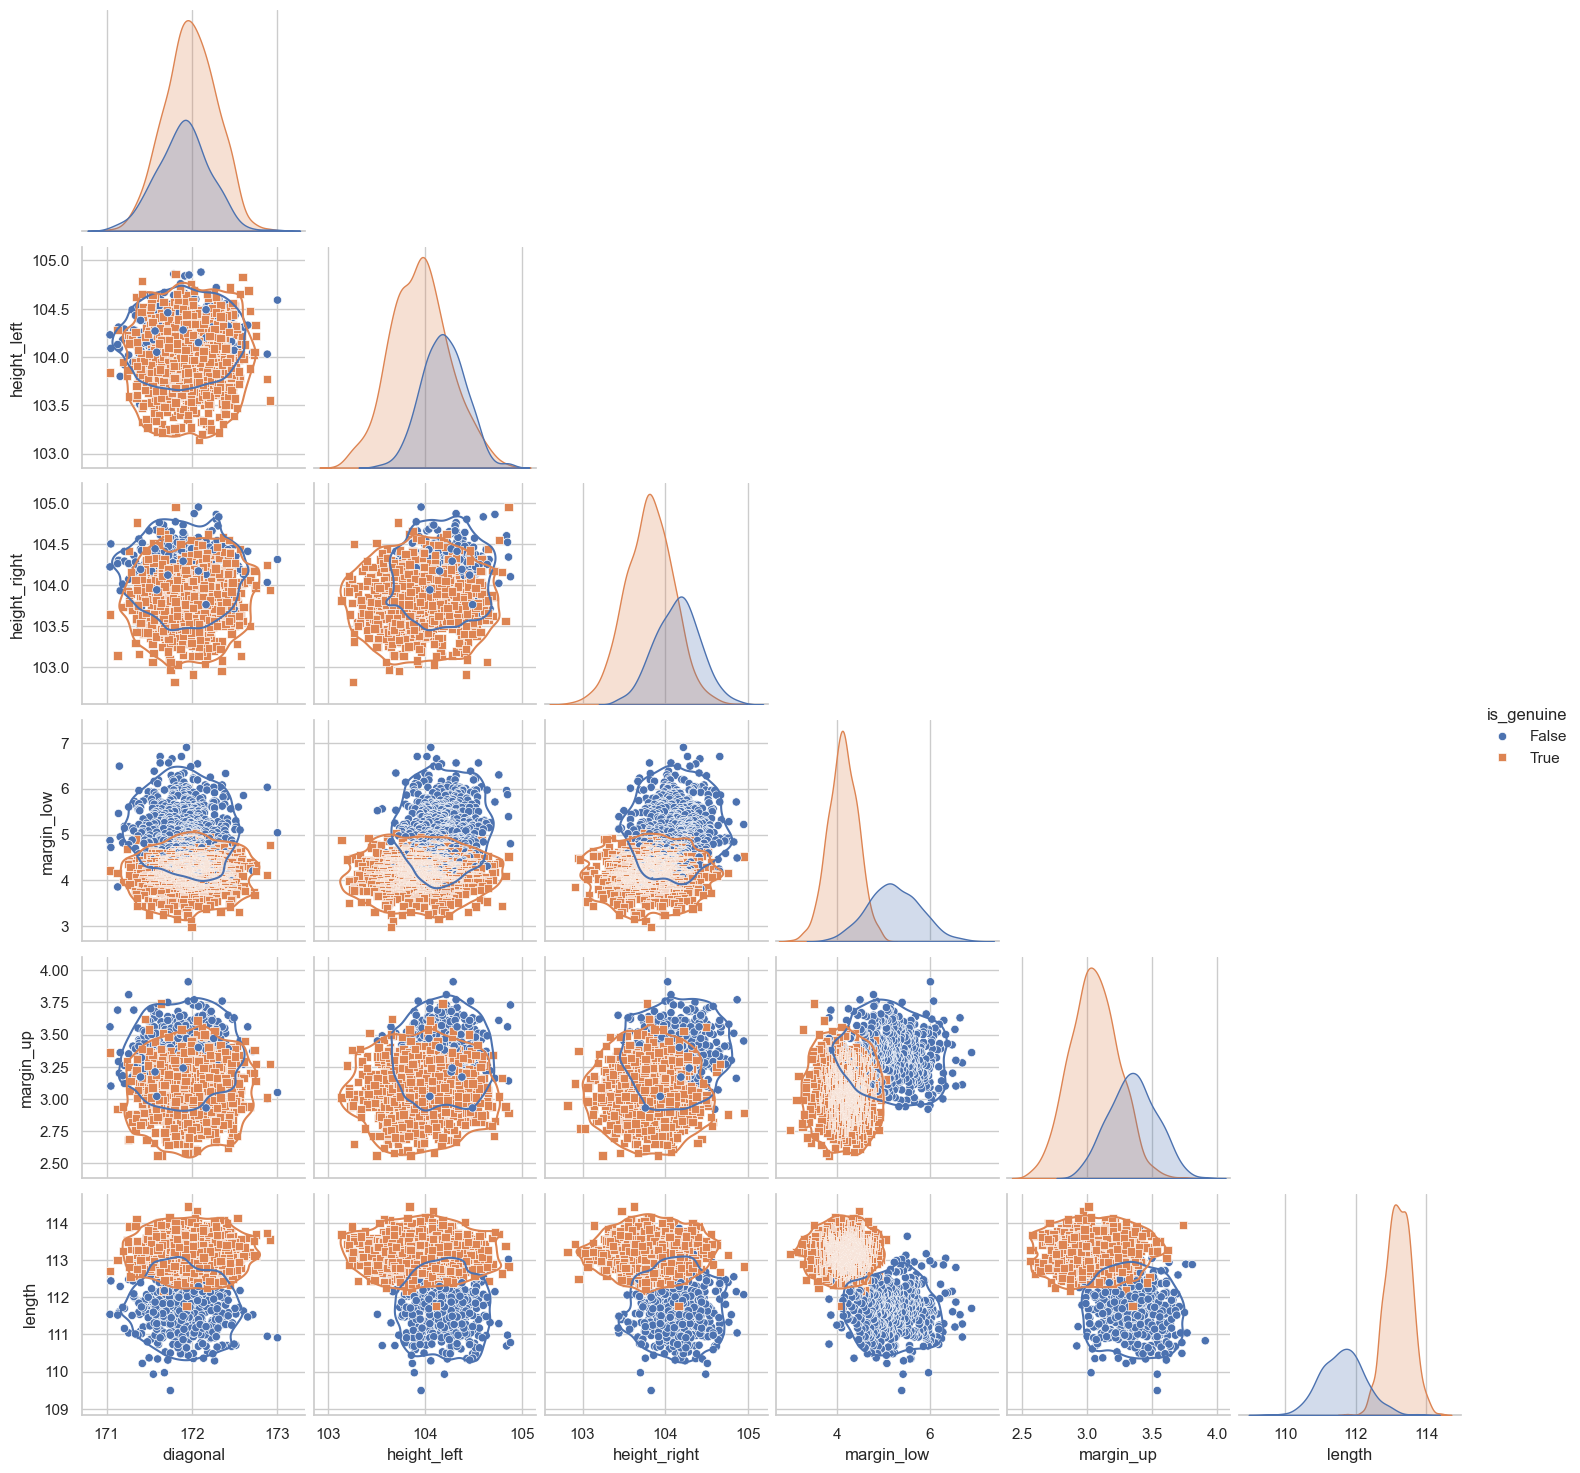

In [14]:
# Visualisation par nuage de points des différentes relations entre les variables
g = sns.pairplot(df_billets, hue='is_genuine', markers=['o','s'], corner=True)
g.map_lower(sns.kdeplot, levels=2, color='.2')

#Afficher
plt.show()

On remaque rapidement qu'avec margin_up, margin_low et length, les groupes se distinguent

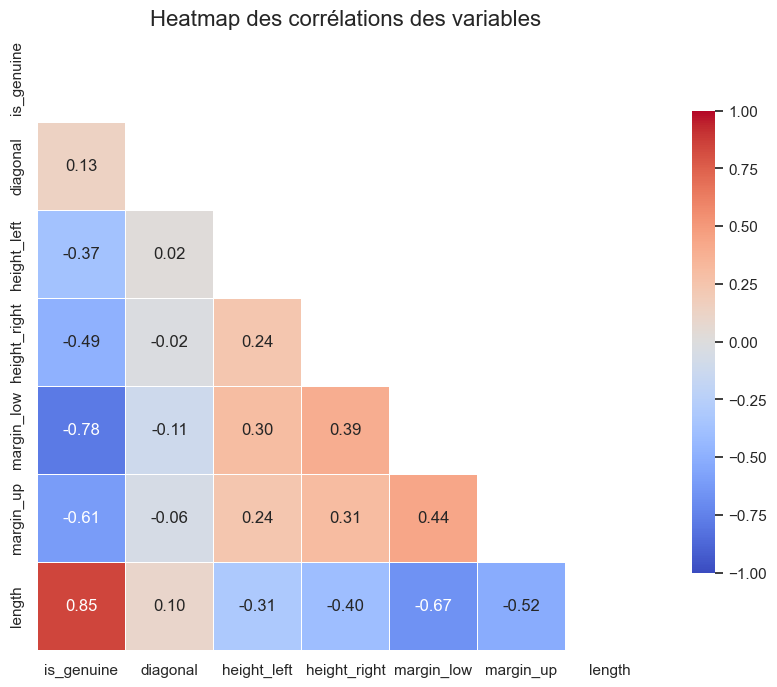

In [16]:
# Avant de tracer la matrice de correlation, il faut toujours enlever les valeurs manquantes
df_selected = df_billets.dropna()

# Visualisation des corrélations avec une heatmap
corr_matrix = df_selected.corr()
# Je souhaite affichier uniquement la partie inférieur du heatmap pour supprimer les redondances
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Définir la taille de la figure
plt.figure(figsize=(10, 8))
# Configurer le style de la carte
sns.set(style="white")

# Dessiner la heatmap
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, 
            square=True, linewidths=.5, cbar_kws={"shrink": .75})

# Ajouter un titre à la heatmap
plt.title('Heatmap des corrélations des variables', size=16)

# Afficher la figure
plt.show()

In [17]:
# On va utiliser une OLS Regression pour connaitre la colinéarité des variables entre margin_low et les autres
# Selection des valeurs X,y
X = df_selected[['diagonal', 'height_left', 'height_right', 'margin_up', 'length']]
y = df_selected['margin_low']

# Ajout d'une constante pour le modèle
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X)
results = model.fit()

# Afficher le sommaire
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.478
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     267.0
Date:                Mon, 22 Jul 2024   Prob (F-statistic):          8.18e-203
Time:                        11:20:18   Log-Likelihood:                -1000.2
No. Observations:                1463   AIC:                             2012.
Df Residuals:                    1457   BIC:                             2044.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           22.8941      9.648      2.373   

### Ici, on vérifie plusieurs paramètres. La plus significatif est la lecture de P>|t|, pour  notre cas on remarque que toutes les variables on un p-vlaue inférieur à 0.05.

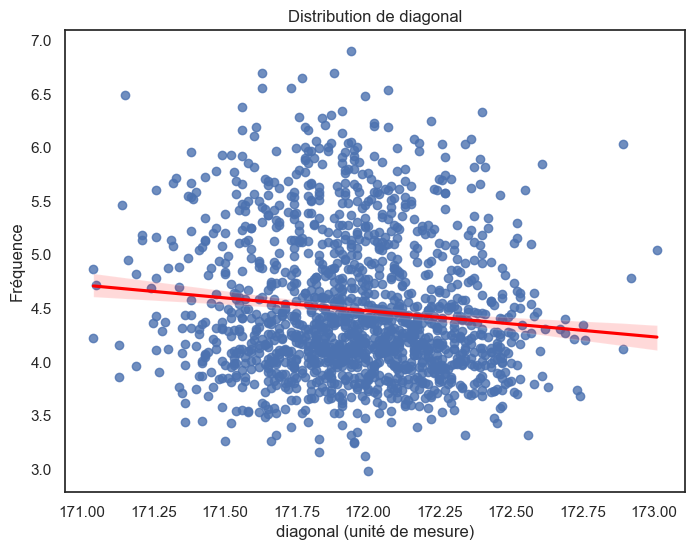

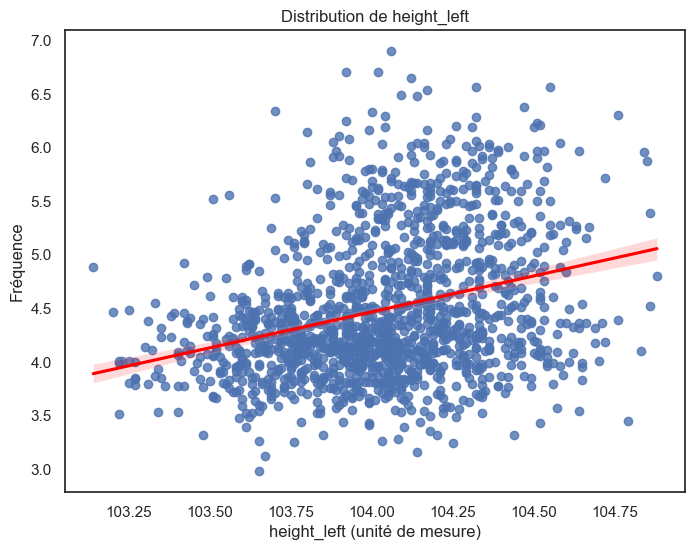

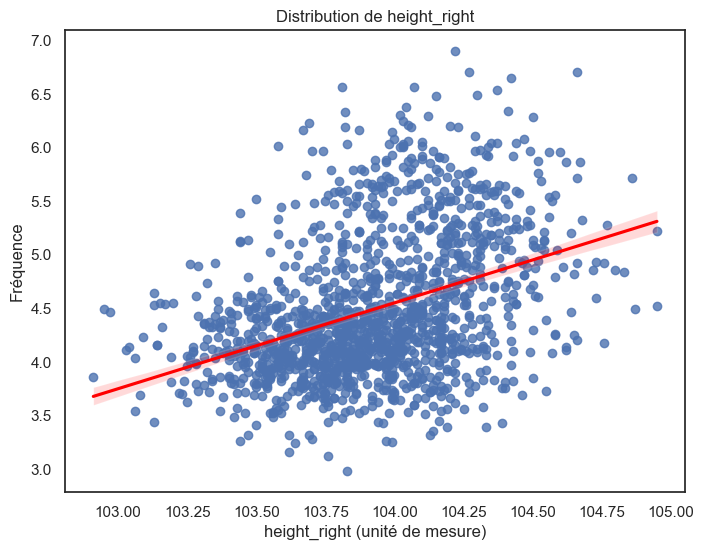

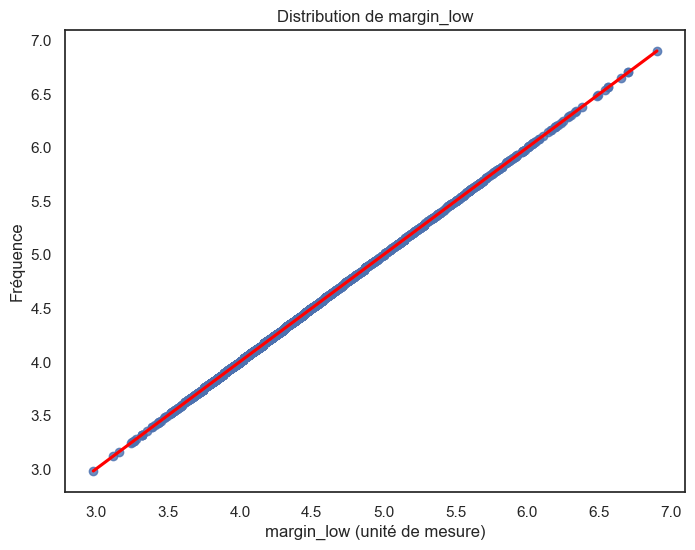

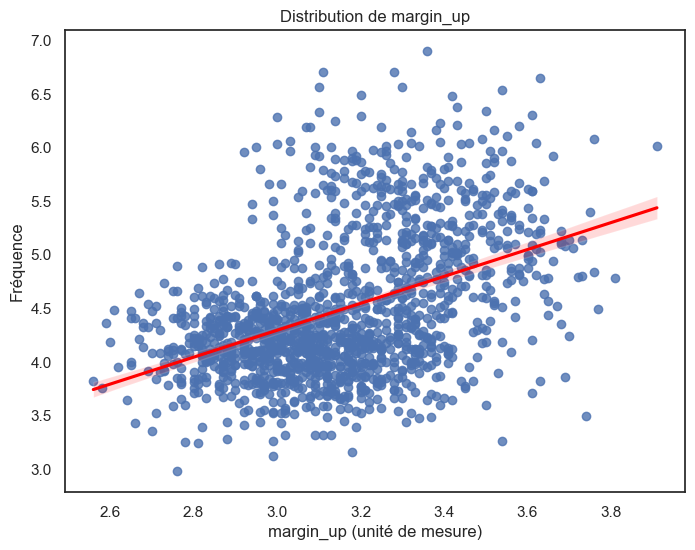

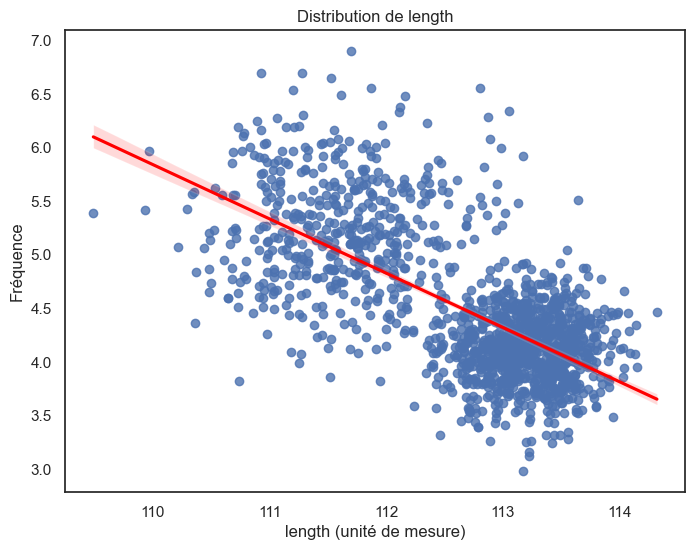

In [19]:
# Afficher les correlations entre margin_low et les autres variables
for dim in dimensions:
    plt.figure(figsize=(8, 6))
    sns.regplot(data=df_selected, x=df_selected[dim], y='margin_low', line_kws={'color': 'red'})
    plt.title(f'Distribution de {dim}')
    plt.xlabel(f'{dim} (unité de mesure)')
    plt.ylabel('Fréquence')
    plt.show()

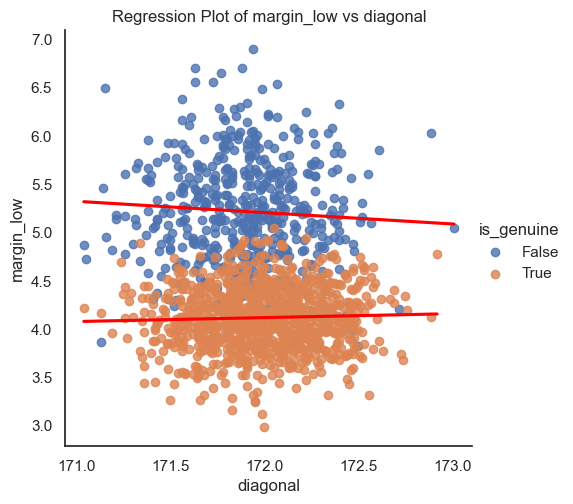

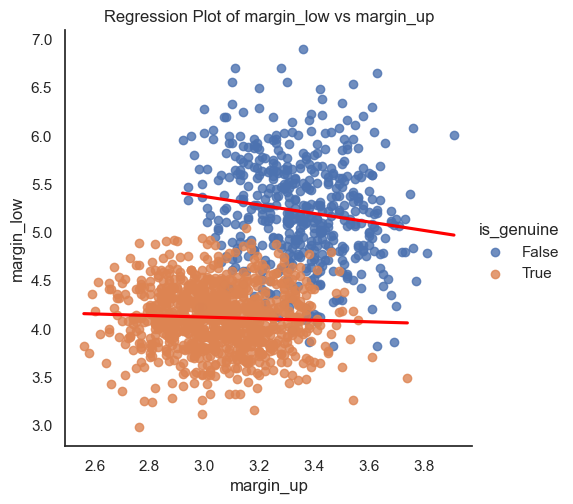

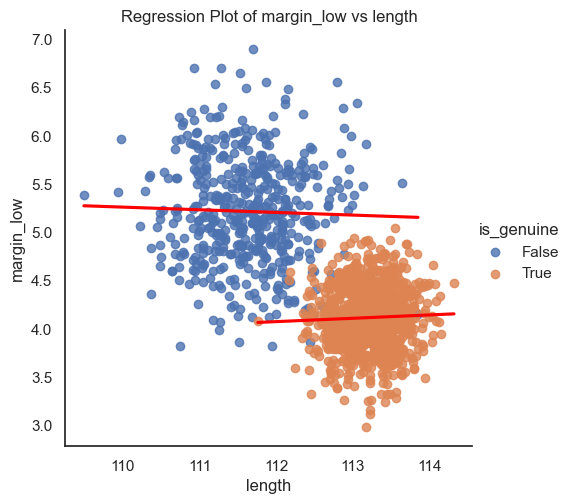

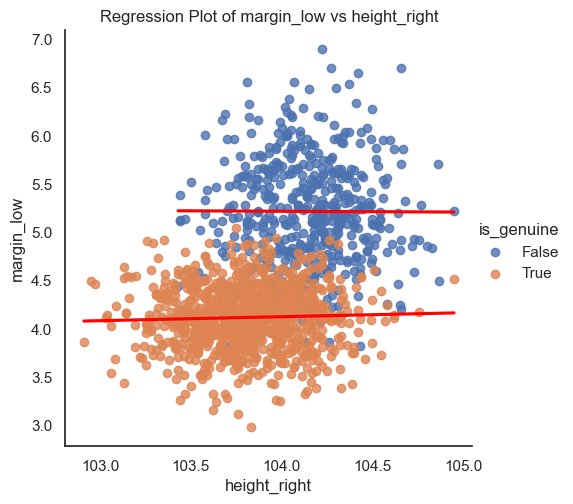

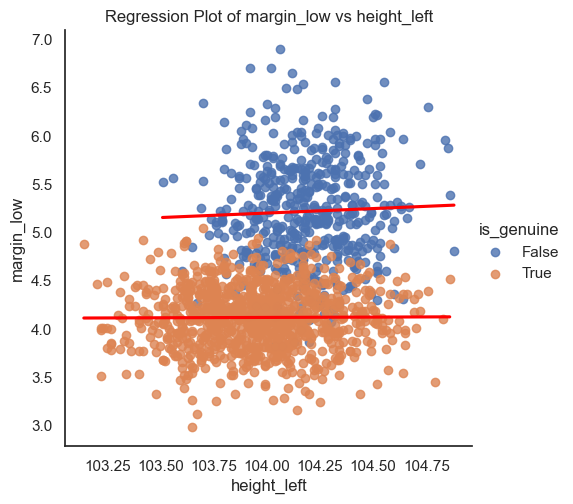

In [20]:
# Définir les variables explicatives
variables = ['diagonal', 'margin_up', 'length', 'height_right', 'height_left']

# Créer un lmplot pour chaque variable explicative
for var in variables:
    sns.lmplot(data=df_selected, x=var, y='margin_low', hue='is_genuine', ci=None, line_kws={'color': 'red'})
    plt.title(f'Regression Plot of margin_low vs {var}')
    plt.show()

<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 3 - Régression linéaire multiple</h2>
</div>

In [22]:
#Encodage de la variable booléenne.
df_selected['is_genuine'] = df_selected['is_genuine'].map({True : 1, False : 0})

# Variables explicatives (X) et cible (y)
X = df_selected[['is_genuine', 'diagonal', 'margin_up', 'length', 'height_right', 'height_left']]
y = df_selected['margin_low']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instanciation et ajustement du modèle de régression linéaire
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [23]:
# Prédiction sur l'ensemble de test
y_pred = reg.predict(X_test)

In [24]:
from sklearn.metrics import r2_score
# Calcul du R²
r_squared = r2_score(y_test, y_pred)

# Calcul du R² ajusté
n = X_test.shape[0]  # Nombre de points de données
p = X_test.shape[1]  # Nombre de variables explicatives
r_squared_adj = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

print("R²:", r_squared)
print("R² ajusté:", r_squared_adj)

R²: 0.5481772529081925
R² ajusté: 0.5386984540181546


In [25]:
# Calcul du coefficient de détermination
r2 = r2_score(y_test, y_pred)
print("Coefficient de détermination R^2 : ", r2)
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
print(f"RMSE: {mean_squared_error(y_test, y_pred)}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, y_pred)}")

Coefficient de détermination R^2 :  0.5481772529081925
RMSE: 0.1793893785252295
MAPE: 0.07318858081958254


Le RMSE et le MAPE ont un très bon score, proche de 0.
Mais le coefficient de détermination R² est faible, il faut trouvé la raison pourquoi le r² est autant petit, il devrait normalement être proche de 1

<div style="border: 1px solid rgb(51, 165, 182); padding: 10px;">
    <h3 style="margin: 0; color: rgb(51, 165, 182);">3.1 Analyse plus approfondie</h3>
</div>

 ## Normalité des résidus

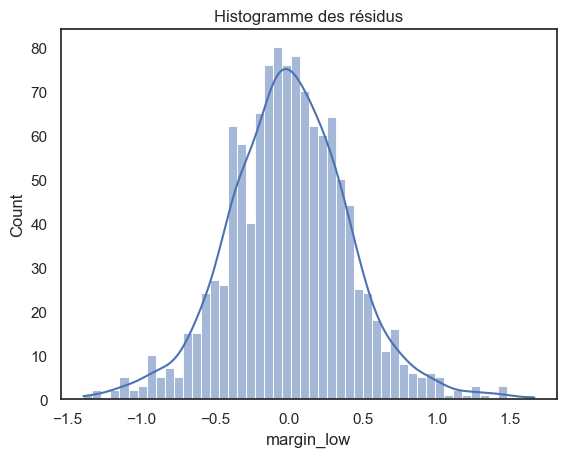

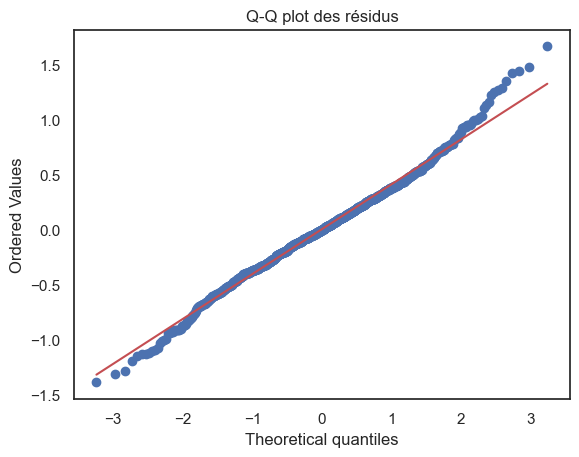

In [29]:
# Calcul des résidus
residuals = y_train - reg.predict(X_train)

# Histogramme des résidus
sns.histplot(residuals, kde=True, bins=50)
plt.title('Histogramme des résidus')
plt.show()

from scipy.stats import probplot
# Q-Q plot des résidus
probplot(residuals, plot=plt)
plt.title('Q-Q plot des résidus')
plt.show()

###  Interprétation du tracé résiduel Q-Q normal
Nos données sont presque parfaitement alignées avec la ligne dans le tracé résiduel Q-Q normal. Il est donc peu nécéssaire d'ajuster le modèle de regression 

## Colinéarité des variables

In [32]:
# Ajouter une constante à X pour l'intercept de la régression
X = sm.add_constant(X)

# Calculer le VIF pour chaque variable explicative
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

       Variable            VIF
0         const  596789.811796
1    is_genuine       4.738018
2      diagonal       1.028266
3     margin_up       1.599711
4        length       3.613190
5  height_right       1.320821
6   height_left       1.173594


Il est peu probable que la colinéarité entre les variables explicatives affecte significativement les estimations du modèle.

## Homoscédasticité

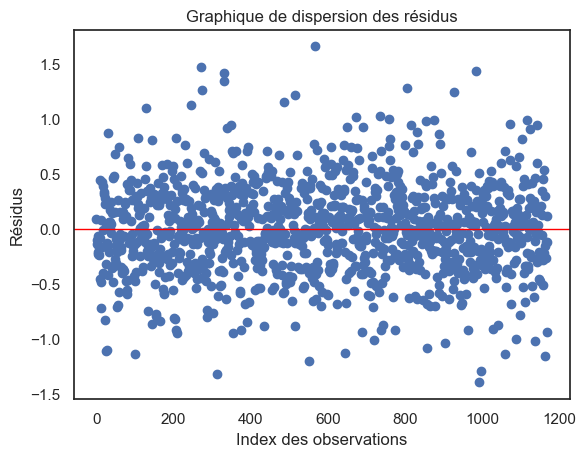

In [35]:
# Graphique de dispersion des résidus
plt.scatter(range(len(residuals)), residuals)
plt.axhline(y=0, color='red', linestyle='-', linewidth=1)  # ligne horizontale à zéro

plt.xlabel('Index des observations')
plt.ylabel('Résidus')
plt.title('Graphique de dispersion des résidus')
plt.show()

### Interpretation du graphique de dispersion des résidus

(1) ils sont assez symétriquement distribués, tendant à se regrouper vers le milieu du tracé.
(2) ils sont regroupés autour des nombres à un chiffre les plus bas de l’axe des ordonnées (par exemple, 0,5 ou 1,5, et non 30 ou 150).
(3) en général, il n’y a pas de tendances nettes.

In [37]:
# 2. Sélectionner les index des valeurs manquantes
missing_indices = df_billets[df_billets['margin_low'].isnull()].index

# 3. Remplacer les valeurs manquantes par les prédictions correspondantes
df_billets.loc[missing_indices, 'margin_low'] = y_pred[:len(missing_indices)]

In [38]:
# Vérification des nouvelles valeurs
print(df_billets.loc[1463:1470, 'margin_low'])

1463    4.074128
1464    5.244324
1465    5.271507
1466    4.093950
1467    4.111154
1468    4.109920
1469    4.136464
1470    4.115396
Name: margin_low, dtype: float64


<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 4 - Méthodes de prédictions</h2>
</div>

<div style="border: 1px solid rgb(51, 165, 182); padding: 10px;">
    <h3 style="margin: 0; color: rgb(51, 165, 182);">4.1 Le K-means</h3>
</div>

K-means n'est pas une méthode pour prédire les valeurs mais pour identifier des clusters dans un groupe de donnée.

On utilisera kmeans afin de vérifier s'il peut déterminer les faux billets en les regroupant en un seul cluster commun?

## Vérifier le nombre optimale de cluster

In [43]:
from sklearn.preprocessing import StandardScaler
# Préparer les données
X = df_billets.drop(columns='is_genuine')
y = df_billets['is_genuine']

# Standardiser les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialisation des listes pour stocker les résultats
range_n_clusters = range(2, 11)
silhouette_avg = []

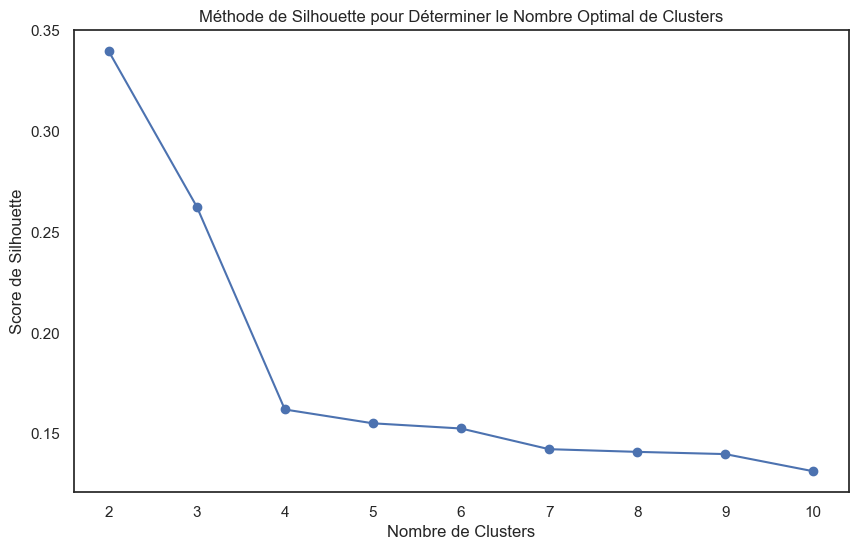

Le nombre optimal de clusters est : 2


In [44]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg.append(silhouette_score(X_scaled, cluster_labels))

# Tracer le score de silhouette pour chaque nombre de clusters
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_avg, marker='o')
plt.title('Méthode de Silhouette pour Déterminer le Nombre Optimal de Clusters')
plt.xlabel('Nombre de Clusters')
plt.ylabel('Score de Silhouette')
plt.show()

# Trouver le nombre optimal de clusters
optimal_n_clusters = range_n_clusters[np.argmax(silhouette_avg)]
print(f'Le nombre optimal de clusters est : {optimal_n_clusters}')

In [45]:
# Créer une copie de df_billets pour le clustering
df_clustered = df_billets.copy()

# Réaliser le clustering K-means avec le nombre optimal de clusters
kmeans = KMeans(n_clusters=2, init="k-means++", n_init=5, max_iter=300, random_state=17)
kmeans.fit(X_scaled)

# Prédire les clusters
clusters = kmeans.predict(X_scaled)

# Ajouter les labels des clusters aux données d'origine
df_clustered['Cluster'] = clusters

# Afficher les premiers résultats des centroïdes
centroids = df_clustered.groupby('Cluster').median()
print(tabulate(centroids, headers='keys', tablefmt='fancy_grid'))

╒═══════════╤══════════════╤════════════╤═══════════════╤════════════════╤══════════════╤═════════════╤══════════╕
│   Cluster │   is_genuine │   diagonal │   height_left │   height_right │   margin_low │   margin_up │   length │
╞═══════════╪══════════════╪════════════╪═══════════════╪════════════════╪══════════════╪═════════════╪══════════╡
│         0 │            1 │     171.99 │        103.95 │         103.81 │      4.11058 │        3.05 │   113.2  │
├───────────┼──────────────┼────────────┼───────────────┼────────────────┼──────────────┼─────────────┼──────────┤
│         1 │            0 │     171.91 │        104.19 │         104.16 │      5.19    │        3.35 │   111.63 │
╘═══════════╧══════════════╧════════════╧═══════════════╧════════════════╧══════════════╧═════════════╧══════════╛


In [46]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
# Calcul de la matrice de confusion
cm = confusion_matrix(y, clusters)

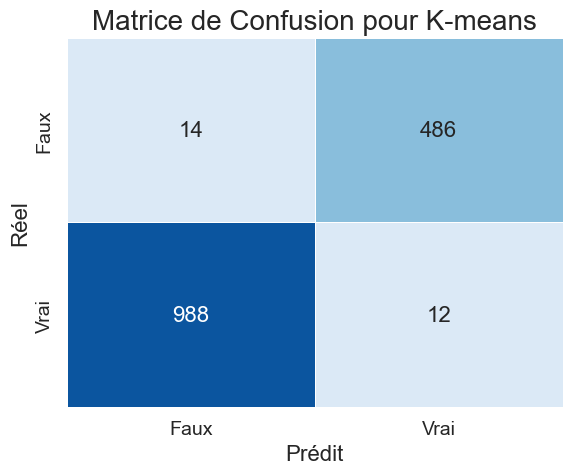

In [47]:
# Amélioration de l'affichage de la matrice de confusion
sns.set(style="whitegrid")

# Choix d'une palette de couleurs plus attrayante
cmap = sns.color_palette("Blues")

# Affichage de la heatmap
sns.heatmap(cm, annot=True, fmt='d', linewidths=.5, annot_kws={"size": 16}, cmap=cmap, cbar=False, 
            xticklabels=['Faux', 'Vrai'], yticklabels=['Faux', 'Vrai'])

plt.title("Matrice de Confusion pour K-means", fontsize=20)
plt.xlabel("Prédit", fontsize=16)
plt.ylabel("Réel", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [48]:
# Calcul des centroïdes
# Obtenir les centroïdes des clusters
centroids = kmeans.cluster_centers_

# Afficher les centroïdes
print("Centroïdes des clusters :")
print(centroids)

Centroïdes des clusters :
[[ 0.09641078 -0.2807449  -0.35382603 -0.54714764 -0.43104492  0.59259053]
 [-0.19398314  0.56487227  0.71191503  1.10088742  0.86728314 -1.19232071]]


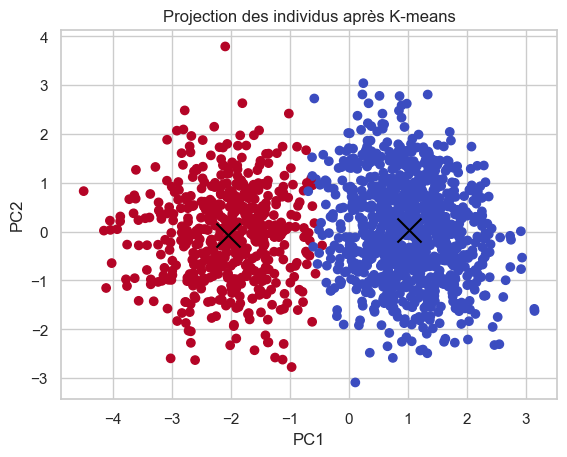

In [49]:
from sklearn.decomposition import PCA

# Réduction de dimensions à 2D pour la visualisation
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Visualisation des clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='coolwarm')
plt.scatter(pca.transform(centroids)[:, 0], pca.transform(centroids)[:, 1], s=300, c='black', marker='x')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Projection des individus après K-means')
plt.show()

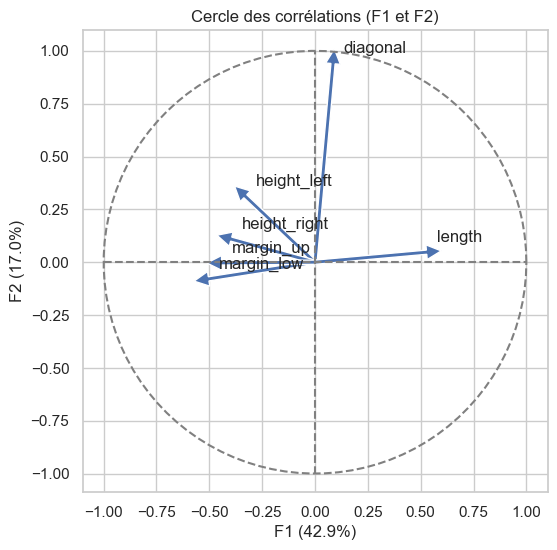

In [50]:
# Créer un DataFrame pour les composants principaux
components_df = pd.DataFrame(pca.components_.T, columns=['F1', 'F2'], index=X.columns)

# Fonction pour dessiner un cercle de corrélations pour deux composantes principales
def plot_correlation_circle(components_df, pca):
    fig, ax = plt.subplots(figsize=(6, 6))
    for i in range(components_df.shape[0]):
        ax.arrow(0, 0, components_df.iloc[i, 0], components_df.iloc[i, 1], 
                 head_width=0.07, head_length=0.07, width=0.02)
        plt.text(components_df.iloc[i, 0] + 0.05, components_df.iloc[i, 1] + 0.05, 
                 components_df.index[i])

    # affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel(f'F1 ({round(100 * pca.explained_variance_ratio_[0], 1)}%)')
    plt.ylabel(f'F2 ({round(100 * pca.explained_variance_ratio_[1], 1)}%)')

    plt.title("Cercle des corrélations (F1 et F2)")

    # Ajouter un cercle unitaire pour l'échelle
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an), color='grey', ls='--')

    plt.axis('equal')
    plt.show()

# Appel de la fonction pour dessiner le cercle des corrélations
plot_correlation_circle(components_df, pca)

<div style="border: 1px solid rgb(51, 165, 182); padding: 10px;">
    <h3 style="margin: 0; color: rgb(51, 165, 182);">4.2 Régression logistique</h3>
</div>

In [52]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold

#Préparation des Données
# Séparer les variables indépendantes et la variable dépendante
X = df_billets.drop('is_genuine', axis=1)
y = df_billets['is_genuine'].astype(int)  # Convertir les valeurs booléennes en entiers

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardiser les données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [53]:
# Ajustement du Modèle et Validation Croisée
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# Instanciation du modèle de régression logistique
logistic_model = LogisticRegression()

# Ajustement du modèle sur l'ensemble d'entraînement complet
logistic_model.fit(X_train_scaled, y_train)

# Prédiction sur l'ensemble de test
y_pred = logistic_model.predict(X_test_scaled)
y_pred_proba = logistic_model.predict_proba(X_test_scaled)[:, 1]

# Validation croisée
cv_scores = cross_val_score(logistic_model, X, y, cv=cv, scoring="accuracy")
print("Validation Croisée - Scores d'Accuracy : ", cv_scores)
print("Validation Croisée - Moyenne des Scores : ", np.mean(cv_scores))

Validation Croisée - Scores d'Accuracy :  [0.98666667 0.99333333 0.98666667 0.99333333 1.         0.97333333
 0.98666667 0.96       0.98666667 0.99333333 0.96666667 0.99333333
 0.99333333 0.99333333 0.98       0.98666667 0.98       0.98
 1.         0.98666667 1.         0.96666667 0.99333333 0.97333333
 0.99333333 0.97333333 0.99333333 0.99333333 0.98666667 0.98666667]
Validation Croisée - Moyenne des Scores :  0.986


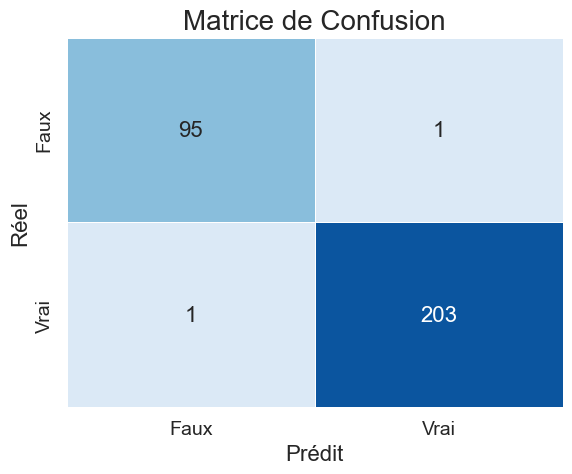

Accuracy sur l'ensemble de test:  0.9933333333333333
Matrice de Confusion:
 [[ 95   1]
 [  1 203]]
Rapport de Classification:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99        96
           1       1.00      1.00      1.00       204

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



In [54]:
# Calcul de la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Amélioration de l'affichage de la matrice de confusion
sns.set(style="whitegrid")

# Choix d'une palette de couleurs plus attrayante
cmap = sns.color_palette("Blues")

# Affichage de la heatmap
sns.heatmap(cm, annot=True, fmt='d', linewidths=.5, annot_kws={"size": 16}, cmap=cmap, cbar=False, 
            xticklabels=['Faux', 'Vrai'], yticklabels=['Faux', 'Vrai'])

plt.title("Matrice de Confusion", fontsize=20)
plt.xlabel("Prédit", fontsize=16)
plt.ylabel("Réel", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# Affichage du rapport de classification et de l'accuracy
print("Accuracy sur l'ensemble de test: ", accuracy_score(y_test, y_pred))
print("Matrice de Confusion:\n", cm)
print("Rapport de Classification:\n", classification_report(y_test, y_pred))

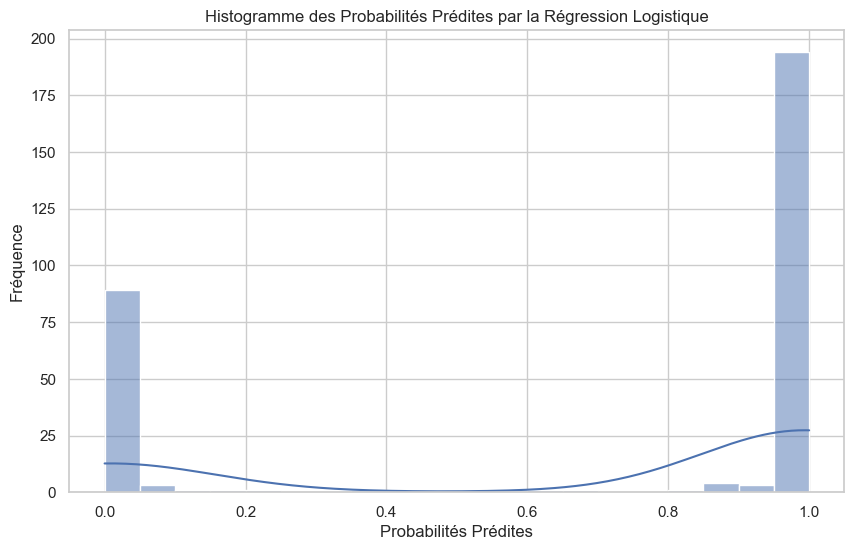

In [55]:
# Tracer l'histogramme des probabilités
plt.figure(figsize=(10, 6))
sns.histplot(y_pred_proba, bins=20, kde=True)
plt.title('Histogramme des Probabilités Prédites par la Régression Logistique')
plt.xlabel('Probabilités Prédites')
plt.ylabel('Fréquence')
plt.show()

Le modèle est assez fiable au niveau de ses prédictions, la plupart des prédictions ont une probabilité proche de 0 ou de 1.

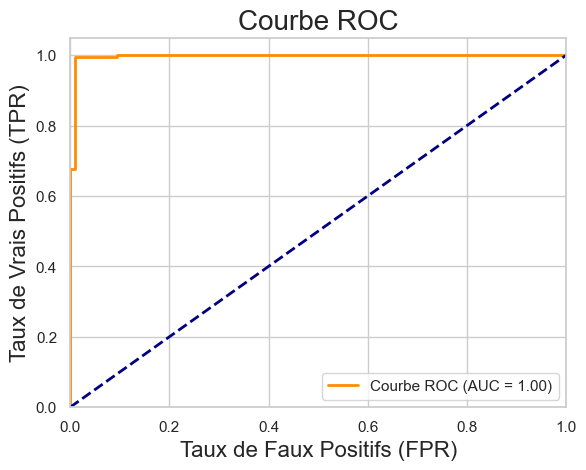

In [57]:
# Calcul de la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Affichage de la courbe ROC
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Courbe ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (FPR)', fontsize=16)
plt.ylabel('Taux de Vrais Positifs (TPR)', fontsize=16)
plt.title('Courbe ROC', fontsize=20)
plt.legend(loc="lower right")
plt.show()

Plus la courbe se rapproche du coin en haut à gauche, meilleur est le modèle. La diagonale correspond à un modèle purement aléatoire.

In [59]:
import pickle
# Sauvegarder le modèle entraîné et le scaler
with open('logistic_model.pkl', 'wb') as file:
    pickle.dump(logistic_model, file)
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

<div style="border: 1px solid rgb(51, 165, 182); padding: 10px;">
    <h3 style="margin: 0; color: rgb(51, 165, 182);">4.3 Le KNN</h3>
</div>

In [61]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict, KFold
#Préparation des Données
# Séparer les variables indépendantes et la variable dépendante
X = df_billets.drop('is_genuine', axis=1)
y = df_billets['is_genuine'].astype(int)  # Convertir les valeurs booléennes en entiers

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Création d'un classifieur KNN
knn_cv = KNeighborsClassifier(n_neighbors=12)

# Entraîner le classifieur KNN sur l'ensemble d'entraînement
knn_cv.fit(X_train, y_train)

# Prédire sur l'ensemble de test
y_pred_knn = knn_cv.predict(X_test)

In [62]:
from sklearn.model_selection import GridSearchCV
#create new a knn model
knn2 = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25)}
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)
#fit model to data
knn_gscv.fit(X, y)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])})

In [63]:
#check top performing n_neighbors value
knn_gscv.best_params_

{'n_neighbors': 12}

In [64]:
#check mean score for the top performing value of n_neighbors
knn_gscv.best_score_

0.978

In [65]:
# Validation croisée pour estimer la précision
cv_scores = cross_val_score(knn_cv, X, y, cv=cv, scoring='accuracy')
print("Validation Croisée - Scores d'Accuracy : ", cv_scores)
print("Validation Croisée - Moyenne des Scores : ", np.mean(cv_scores))

# Calculer la matrice de confusion avec les prédictions de l'ensemble de test
cm_knn = confusion_matrix(y_test, y_pred_knn)

Validation Croisée - Scores d'Accuracy :  [0.98       1.         0.98666667 0.98666667 1.         0.97333333
 0.99333333 0.96666667 0.99333333 0.98666667 0.97333333 0.98666667
 0.99333333 0.99333333 0.98       0.99333333 0.97333333 0.98666667
 1.         0.98666667 0.99333333 0.97333333 1.         0.98
 0.98666667 0.97333333 0.99333333 0.99333333 0.98666667 0.99333333]
Validation Croisée - Moyenne des Scores :  0.9868888888888888


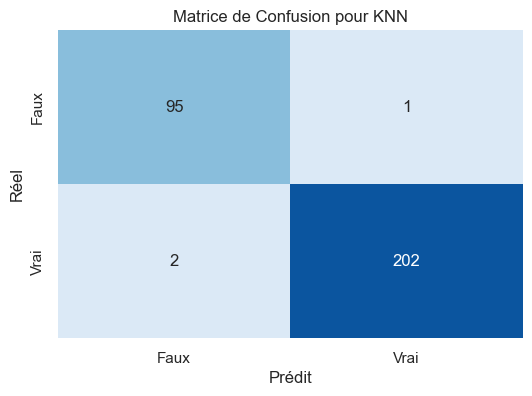

In [66]:
# Amélioration de l'affichage de la matrice de confusion
sns.set(style="whitegrid")
cmap = sns.color_palette("Blues")

# Affichage de la heatmap de la matrice de confusion pour les prédictions sur l'ensemble de test
plt.figure(figsize=(6, 4))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap=cmap, cbar=False,
            xticklabels=['Faux', 'Vrai'], yticklabels=['Faux', 'Vrai'])
plt.title("Matrice de Confusion pour KNN")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()

In [67]:
# Affichage du rapport de classification et de l'accuracy
print("Accuracy sur l'ensemble de test: ", accuracy_score(y_test, y_pred_knn))
print("Matrice de Confusion:\n", cm_knn)
print("Rapport de Classification:\n", classification_report(y_test, y_pred_knn))

Accuracy sur l'ensemble de test:  0.99
Matrice de Confusion:
 [[ 95   1]
 [  2 202]]
Rapport de Classification:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98        96
           1       1.00      0.99      0.99       204

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



<div style="border: 1px solid rgb(51, 165, 182); padding: 10px;">
    <h3 style="margin: 0; color: rgb(51, 165, 182);">4.4 Random Forest</h3>
</div>

In [69]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
#Préparation des Données
# Séparer les variables indépendantes et la variable dépendante
X = df_billets.drop('is_genuine', axis=1)
y = df_billets['is_genuine'].astype(int)  # Convertir les valeurs booléennes en entiers

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Création d'un classifieur Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_rf)
print("Accuracy:", accuracy)

Accuracy: 0.99


In [70]:
# Validation croisée pour estimer la précision
cv_scores = cross_val_score(rf, X, y, cv=cv, scoring='accuracy')
print("Validation Croisée - Scores d'Accuracy : ", cv_scores)
print("Validation Croisée - Moyenne des Scores : ", np.mean(cv_scores))

Validation Croisée - Scores d'Accuracy :  [0.98666667 1.         0.98666667 0.98666667 1.         0.97333333
 0.98666667 0.96666667 0.99333333 0.99333333 0.96666667 0.98666667
 0.99333333 0.99333333 0.98       0.98666667 0.98666667 0.99333333
 1.         0.98666667 0.99333333 0.97333333 1.         0.98666667
 0.97333333 0.97333333 0.99333333 0.99333333 0.98666667 0.98666667]
Validation Croisée - Moyenne des Scores :  0.9868888888888888


In [71]:
# Calculer les matrices de confusion avec les prédictions de l'ensemble de test
cm_rf = confusion_matrix(y_test, y_pred_rf)

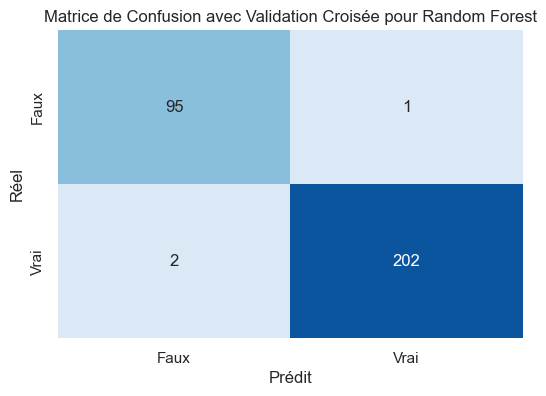

In [72]:
# Affichage de la matrice de confusion
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap=cmap, cbar=False,
            xticklabels=['Faux', 'Vrai'], yticklabels=['Faux', 'Vrai'])
plt.title("Matrice de Confusion avec Validation Croisée pour Random Forest")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()

<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 5 - Test du programme</h2>
</div>

<div style="border: 1px solid rgb(51, 165, 182); padding: 10px;">
    <h3 style="margin: 0; color: rgb(51, 165, 182);">5.1 test du programme sur le fichier de base</h3>
</div>

In [75]:
from sklearn.preprocessing import StandardScaler

# Charger le modèle et le scaler sauvegardés
with open('logistic_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)
with open('scaler.pkl', 'rb') as file:
    loaded_scaler = pickle.load(file)

# Standardiser les données d'origine sans la colonne 'is_genuine'
df_billet_drop = df_billets.drop('is_genuine', axis=1)
df_billet_drop_scaled = loaded_scaler.transform(df_billet_drop)

# Faire des prédictions
new_predictions = loaded_model.predict(df_billet_drop_scaled)

# Ajouter les prédictions au DataFrame d'origine
df_billets['is_predicted_genuine'] = new_predictions

# Convertir 1 en True et 0 en False
df_billets['is_predicted_genuine'] = df_billets['is_predicted_genuine'].map({1: True, 0: False})

# Afficher les résultats
print(df_billets)

      is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0          False    171.94       104.06        104.22    6.900000       3.36   
1          False    171.63       104.02        104.66    6.700000       3.28   
2          False    171.88       103.92        104.27    6.700000       3.11   
3          False    171.77       104.12        104.42    6.650000       3.63   
4          False    171.73       104.32        104.07    6.560000       3.30   
...          ...       ...          ...           ...         ...        ...   
1495       False    172.17       104.49        103.76    4.066899       2.93   
1496       False    172.08       104.15        104.17    4.116942       3.40   
1497       False    171.72       104.46        104.12    4.095103       3.61   
1498       False    172.66       104.33        104.41    5.191146       3.56   
1499       False    171.90       104.28        104.29    5.194115       3.24   

      length  is_predicted_genuine  
0 

In [76]:
# Vérifier les différences entre les prédictions et les valeurs réelles
discrepancies = df_billets.loc[df_billets['is_predicted_genuine'] != df_billets['is_genuine'], :]
discrepancies

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,is_predicted_genuine
105,False,171.56,103.80,103.87,5.660000,2.98,112.95,True
187,False,171.65,104.19,103.96,5.370000,2.99,112.86,True
488,False,171.85,103.60,103.82,4.600000,3.21,112.50,True
496,True,171.67,103.81,103.76,4.590000,3.30,112.18,False
642,False,171.88,104.05,103.75,4.410000,3.21,112.52,True
778,False,172.13,103.67,103.82,4.270000,3.22,112.15,True
836,False,172.02,103.99,104.28,4.220000,2.98,112.42,True
926,False,172.09,104.15,104.17,4.150000,3.40,113.85,True
938,False,172.25,103.94,103.68,4.140000,3.25,112.48,True
948,False,172.39,104.05,104.32,4.130000,3.41,112.66,True


<div style="border: 1px solid rgb(51, 165, 182); padding: 10px;">
    <h3 style="margin: 0; color: rgb(51, 165, 182);">5.2 - Programme detection de faux billets </h3>
</div>

**Modèle de Régression Logistique pour la Détection de Faux Billets**

- **Entraînement du Modèle :** Le modèle a été entraîné sur un jeu de données comprenant des caractéristiques telles que la diagonale, les marges, et les hauteurs des billets.
  
- **Utilisation :** Pour l'utiliser, chargez vos données, appliquez la standardisation avec le scaler fourni, puis utilisez le modèle pour prédire la véracité des billets.


In [79]:
import pickle
import pandas as pd
from tabulate import tabulate

def detection_faux_billets(file_path, model):
    # Charger le modèle et le scaler sauvegardés
    with open('logistic_model.pkl', 'rb') as file:
        loaded_model = pickle.load(file)
    with open('scaler.pkl', 'rb') as file:
        loaded_scaler = pickle.load(file)
    
    # Charger le nouveau jeu de données à prédire
    df_prediction = pd.read_csv(file_path)
    
    # Prétraiter les nouvelles données avec le scaler chargé
    df_prediction = df_prediction[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']]
    df_prediction_scaled = loaded_scaler.transform(df_prediction)
    
    # Faire des prédictions avec le modèle fourni en argument
    new_predictions = model.predict(df_prediction_scaled)

    # Calculer les probabilités
    probabilites = model.predict_proba(df_prediction_scaled)
    
    # Ajouter les prédictions au dataframe
    df_prediction['prediction'] = new_predictions
    
    # Convertir 1 en 'Vrai' et 0 en 'Faux'
    df_prediction['prediction'] = df_prediction['prediction'].map({1: 'Vrai', 0: 'Faux'})

    # Ajouter les prédictions et les probabilités au DataFrame
    df_prediction['Probabilite'] = probabilites[:, 1]
    df_prediction['Probabilite'] = df_prediction['Probabilite'].round(4)
    
    # Afficher les résultats
    print(tabulate(df_prediction, headers='keys', tablefmt='fancy_grid'))

In [80]:
# Utilisation de la fonction pour prédire avec le modèle chargé
detection_faux_billets('billets_production.csv', loaded_model)

╒════╤════════════╤═══════════════╤════════════════╤══════════════╤═════════════╤══════════╤══════════════╤═══════════════╕
│    │   diagonal │   height_left │   height_right │   margin_low │   margin_up │   length │ prediction   │   Probabilite │
╞════╪════════════╪═══════════════╪════════════════╪══════════════╪═════════════╪══════════╪══════════════╪═══════════════╡
│  0 │     171.76 │        104.01 │         103.54 │         5.21 │        3.3  │   111.42 │ Faux         │        0.0015 │
├────┼────────────┼───────────────┼────────────────┼──────────────┼─────────────┼──────────┼──────────────┼───────────────┤
│  1 │     171.87 │        104.17 │         104.13 │         6    │        3.31 │   112.09 │ Faux         │        0.0003 │
├────┼────────────┼───────────────┼────────────────┼──────────────┼─────────────┼──────────┼──────────────┼───────────────┤
│  2 │     172    │        104.58 │         104.29 │         4.99 │        3.39 │   111.57 │ Faux         │        0.0003 │
├────┼──